<a href="https://colab.research.google.com/github/MichalSlowakiewicz/Machine-Learning/blob/master/Lab12-NLP-towards-attention212.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U datasets

In [2]:
from datasets import load_dataset
import collections
import re                             # Regular Expressions: for text searching and cleaning

MAX_LEN = 128

# Load Yelp Polarity dataset from Hugging Face (one-time use)
raw = load_dataset("yelp_polarity")

N_TRAIN = 100_000
N_TEST = 20_000   # VAL + TEST sets

train_raw = raw["train"].shuffle(seed=42).select(range(N_TRAIN))
test_raw  = raw["test"].shuffle(seed=42).select(range(N_TEST))


# Extract plain Python lists for text and labels
def to_lists(dataset):
    texts = []
    labels = []
    for example in dataset:
        texts.append(example["text"])
        labels.append(example["label"])
    return texts, labels

train_texts, train_labels = to_lists(train_raw)
test_texts, test_labels   = to_lists(test_raw)

# Split test set into val/test
from sklearn.model_selection import train_test_split
val_texts, test_texts, val_labels, test_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=42
)

# Show class counts
def print_distribution(name, labels):
    c = collections.Counter(labels)
    total = sum(c.values())
    print(f"\n{name} distribution:")
    for label in sorted(c.keys()):
        print(f"  {label}: {c[label]} ({c[label]/total:.2%})")

print_distribution("Train", train_labels)
print_distribution("Validation", val_labels)
print_distribution("Test", test_labels)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.93k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]


Train distribution:
  0: 50209 (50.21%)
  1: 49791 (49.79%)

Validation distribution:
  0: 5038 (50.38%)
  1: 4962 (49.62%)

Test distribution:
  0: 4973 (49.73%)
  1: 5027 (50.27%)


In [3]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.split()

def build_vocab(token_lists, min_freq=2):
    counter = collections.Counter(token for tokens in token_lists for token in tokens)
    vocab = {
        token: idx + 2  # reserve 0: <PAD>, 1: <UNK>
        for idx, (token, count) in enumerate(counter.items())
        if count >= min_freq
    }
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

def tokens_to_ids(tokens, vocab):
    return [vocab.get(tok, vocab['<UNK>']) for tok in tokens]   #for unknown tokens return vocab['<UNK>'] (which is == 1)

def pad(seq, max_len=128, pad_value=0):
    return seq + [pad_value] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

def process_texts(texts, vocab, max_len=128):
    return [pad(tokens_to_ids(tokenize(text), vocab), max_len) for text in texts]


# Tokenize training set and build vocab
train_tokens = [tokenize(t) for t in train_texts]
vocab = build_vocab(train_tokens)

# Process splits into padded input_ids
train_ids = process_texts(train_texts, vocab, MAX_LEN)
val_ids   = process_texts(val_texts, vocab, MAX_LEN)
test_ids  = process_texts(test_texts, vocab, MAX_LEN)

# Print 5 real examples: raw text, tokenized, and input IDs
shown = 0
for i in range(len(train_texts)):
    if 1 in train_ids[i][:5]:  # 1 is <UNK>
        print(f"Original:   {train_texts[i]}")
        print(f"Tokenized:  {train_tokens[i]}")
        print(f"Input IDs:  {train_ids[i]}\n")
        shown += 1
        if shown >= 5:
            break


Original:   I've been to Benihannas several times in a California and Arizona. I must say that there isn't any consistency with this place. The one here in chandler is not very good. I think they are surviving off of the reputation not customer service. First the girl working as the hostess needs to learn how to smile and actually act like she likes her job. Word of advice for her. If you can't smile, be cordial, have a personality then quit and find another line of work but obviously interacting with the public is not your calling. \n\nVery long wait to eat.... The servers are slow and you have to wait forever just to get drinks and refills...\n\nI think for $100 I can spend it elsewhere and get better service and food...
Tokenized:  ['i', 've', 'been', 'to', 'benihannas', 'several', 'times', 'in', 'a', 'california', 'and', 'arizona', 'i', 'must', 'say', 'that', 'there', 'isn', 't', 'any', 'consistency', 'with', 'this', 'place', 'the', 'one', 'here', 'in', 'chandler', 'is', 'not', 've

## Notice!

Notice that the `<UNK>` token (coded as 1) is visible in the rows above. Also, there is an abundance of `<PAD>` tokens (coded as 0).

# Prepare Data Loaders
--------------------

We must transform the pandas dataframe to the dataset - it will, among other things, separate input data and labels and then wrap it in a dataloder.

In [4]:
import torch

BATCH_SIZE = 1024

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Convert all to tensors
def to_loader(input_ids, labels, batch_size=1024, shuffle=False):
    x_tensor = torch.tensor(input_ids, dtype=torch.long)
    y_tensor = torch.tensor(labels, dtype=torch.long)
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_tensor, y_tensor), batch_size=batch_size, shuffle=shuffle)

train_loader = to_loader(train_ids, train_labels, BATCH_SIZE, shuffle=True)
val_loader   = to_loader(val_ids, val_labels, BATCH_SIZE)
test_loader  = to_loader(test_ids, test_labels, BATCH_SIZE)


# Training Loop as We Already Got to Know It Well
----------------

## Train Loop Function

In [5]:
import time
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

def train_model(net, train_loader, val_loader, epochs=1000, lr=0.001, log_every=10):
    print(f"Working on {device}")
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    start_time = time.time()

    for epoch in range(epochs):
        net.train()
        train_loss_sum = 0.0
        train_correct = 0
        train_total = 0

        for batch_inputs, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device).float()  # shape: (batch_size)

            optimizer.zero_grad()
            logits = net(batch_inputs)  # logits shape: (batch_size, 1)
            loss = criterion(logits, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * batch_inputs.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            train_correct += (preds == batch_labels).sum().item()
            train_total += batch_inputs.size(0)

        avg_train_loss = train_loss_sum / train_total
        train_acc = train_correct / train_total
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_acc)

        # === Validation ===
        net.eval()
        val_loss_sum = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_inputs, batch_labels in val_loader:
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device).float()

                logits = net(batch_inputs)
                loss = criterion(logits, batch_labels)

                val_loss_sum += loss.item() * batch_inputs.size(0)
                preds = (torch.sigmoid(logits) > 0.5).float()
                val_correct += (preds == batch_labels).sum().item()
                val_total += batch_inputs.size(0)

        avg_val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_acc)

        if epoch % log_every == 0:
            print(f"Epoch {epoch:03d} | "
                  f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time:.2f} seconds")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

Working on cuda


## Plot Function

In [6]:
import matplotlib.pyplot as plt

def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    axs[0].plot(train_loss, label="Train Loss", color='blue')
    axs[0].plot(val_loss, label="Val Loss", color='orange')
    axs[0].set_title("Loss per Epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Average Loss")
    axs[0].grid(True)
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(train_acc, label="Train Accuracy", color='green')
    axs[1].plot(val_acc, label="Val Accuracy", color='red')
    axs[1].set_title("Accuracy per Epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# More Features, Now
---------------

Working on cuda
Epoch 000 | Train Loss: 0.6643, Acc: 0.6006 | Val Loss: 0.6277, Acc: 0.6909
Epoch 010 | Train Loss: 0.2222, Acc: 0.9203 | Val Loss: 0.2515, Acc: 0.9058
Epoch 020 | Train Loss: 0.1686, Acc: 0.9406 | Val Loss: 0.2396, Acc: 0.9122
Epoch 030 | Train Loss: 0.1400, Acc: 0.9516 | Val Loss: 0.2508, Acc: 0.9078
Elapsed time: 101.78 seconds


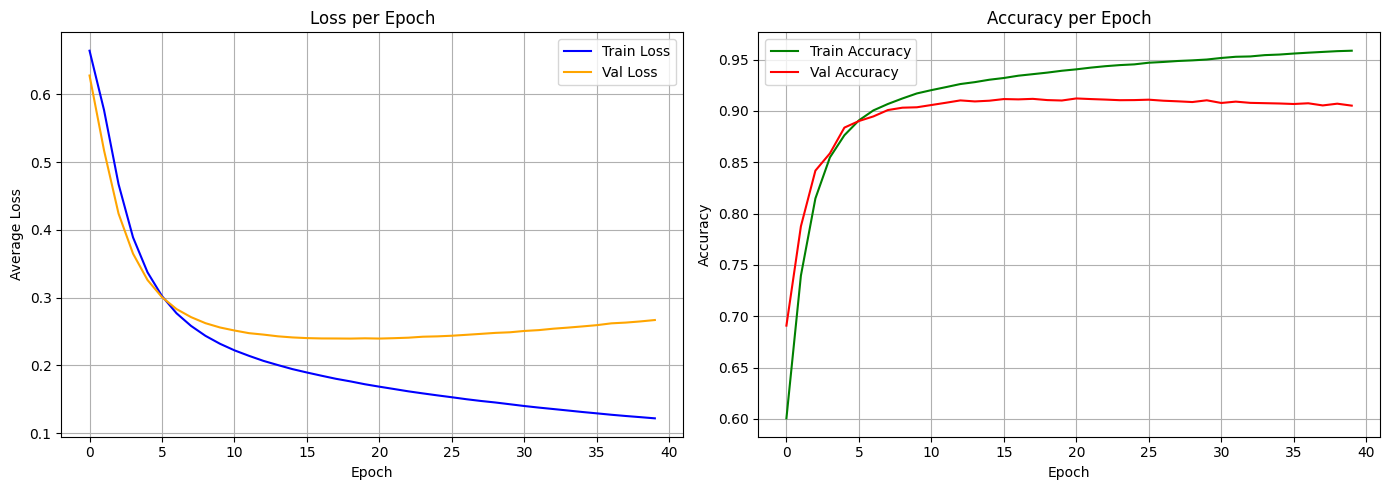

In [7]:
feature_cnt = 300
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_F(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                        #batch, words
        features = self.embedding(index)             #batch, words, features
        features = features.mean(-2)                 #batch, features
        classifications = self.classifier(features)  #batch, 1
        logits = classifications.squeeze(-1)         #batch
        return logits

net_64=Net_F()
train_loss, val_loss, train_acc, val_acc = train_model(net_64, train_loader, val_loader, epochs=40)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

# **Homework Assignment: Is a *queen* really just a *king*, minus a *man*, plus a *woman*?**

--------------



In class, we dealt with **embeddings** trained for **sentiment classification**. These embeddings are optimized to separate *positive* from *negative* expressions and **do not encode deeper semantic information**.

However, in modern natural language processing, there exist other embeddings — such as those from **BERT**, **word2vec**, or **GloVe** — that **do capture semantic structure**. These models are trained on large corpora, and their embeddings often allow for meaningful **vector arithmetic**, like the famous:

```
embedding("king") - embedding("man") + embedding("woman") ≈ embedding("queen")
```

This homework explores **semantic vector relationships** using such pretrained embeddings.

## **The Objective**

Your task is to:

1. Construct semantic classes of word pairs.
2. Visualize them using PCA.
3. Explore arithmetic operations in embedding space.

## **Tasks & Deliverables**

### 1. **Semantic Pair Classes**

- You must gather **at least 10 classes** of semantically related word pairs.
- Each class must contain **at least 5 pairs**.
- That gives a **minimum total of 100 unique words** (10 classes x 5 pairs x 2 words per pair).

Two example classes:

**Class 1: Gender**

- (king, queen)
- (man, woman)
- (doctor, nurse)
- (prince, princess)
- *(you must add one more)*

**Class 2: Verb tense (past tense)**

- (bring, brought)
- (get, got)
- (like, liked)
- *(you must add two more)*

**Your job:**

- Invent or search for **at least 10 such classes**, including the examples above.
- Each class must be conceptually coherent.
- Other examples: singular/plural, country/capital, comparative/superlative, tool/user, job/object, etc.

### 2. **Global PCA (Across All Words)**

- Use PCA to reduce the **entire set of 100 word embeddings** to 2D, and plot it.
- Plot the additional **10 separate charts**, one for each class.
  - Each chart should display only the 10 words (5 pairs) of the given class.
- Points should be labeled with the words themselves.

### 3. **Local PCA (Per Class)**

- For each class (10 total), perform PCA **only** on the 10 words of that class.
- Plot these class-wise PCA visualizations as separate charts.
- Again, points should be labeled with the words.

**Total: 21 charts**
(1 global plot with 100 words + 10 global-space class plots + 10 local PCA class plots)

Charts should be presented in a self-explanatory manner with clear labels.

### 4. **Embedding Arithmetic**

For each class, choose **one example pair** (e.g., (king, queen)) and perform the operation:

```
embedding(B) - embedding(A) + embedding(C)
```

Where A and B form a known pair, and C is another base word.
For example:

```
embedding("king") - embedding("man") + embedding("woman")
```

* For each such result vector, find the **5 closest word embeddings** (using cosine similarity or Euclidean distance).
* Print the top 5 neighbors **with their distances**.
* Do this **once per class** (i.e., 10 times).

This will make it possible to verify if
 ```
embedding("queen") ≈ embedding("king") - embedding("man") + embedding("woman")
```
for the *gender*-related class.


### 5. **Discussion**

* Analyze and interpret your 21 plots.
* Discuss whether the vector relationships are preserved.
* Does PCA capture semantic differences?
* Are the closest words from the arithmetic meaningful?
* What kinds of relationships are captured, and what are not?
* Are some classes better behaved than others?


### 6. **Publish on GitHub**  
   - Place the Colab notebook in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.


## Acknowledgments

*This homework assignment was inspired by an idea from my master's student **Andrzej Małek**, to whom I would like to express my thanks.*



In [ ]:
!pip install transformers datasets matplotlib scikit-learn --quiet

In [8]:
# setting up semantic classes

semantic_classes = {
    "Gender": [
        ("king", "queen"),
        ("man", "woman"),
        ("father", "mother"),
        ("prince", "princess"),
        ("boy", "girl")
    ],
    "Verb Tense": [
        ("go", "went"),
        ("buy", "bought"),
        ("take", "took"),
        ("eat", "ate"),
        ("run", "ran")
    ],
    "Singular/Plural": [
        ("cat", "cats"),
        ("dog", "dogs"),
        ("car", "cars"),
        ("child", "children"),
        ("house", "houses")
    ],
    "Comparative/Superlative": [
        ("good", "better"),
        ("bad", "worse"),
        ("big", "bigger"),
        ("fast", "faster"),
        ("happy", "happier")
    ],
    "Country/Capital": [
        ("france", "paris"),
        ("italy", "rome"),
        ("germany", "berlin"),
        ("japan", "tokyo"),
        ("canada", "ottawa")
    ],
    "Tool/Object": [
        ("pen", "paper"),
        ("knife", "bread"),
        ("brush", "paint"),
        ("hammer", "nail"),
        ("keyboard", "screen")
    ],
    "Profession/Object": [
        ("chef", "knife"),
        ("artist", "brush"),
        ("writer", "pen"),
        ("musician", "guitar"),
        ("carpenter", "hammer")
    ],
    "Animal/Sound": [
        ("dog", "bark"),
        ("cat", "meow"),
        ("cow", "moo"),
        ("duck", "quack"),
        ("lion", "roar")
    ],
    "Object/Color": [
        ("grass", "green"),
        ("sky", "blue"),
        ("sun", "yellow"),
        ("rose", "red"),
        ("cloud", "white")
    ],
    "Adjective/Antonym": [
        ("hot", "cold"),
        ("light", "dark"),
        ("happy", "sad"),
        ("strong", "weak"),
        ("easy", "hard")
    ]
}


In [9]:
# defining function checking whether words from predefined semantic classes are present within dataset

def validate_semantic_classes(semantic_classes, vocab, token_lists, min_occurrences=2):
    token_freq = collections.Counter(token for tokens in token_lists for token in tokens)
    unk_token_id = vocab.get('<UNK>', 1)

    valid_classes = {}
    invalid_words = set()

    for class_name, pairs in semantic_classes.items():
        valid_pairs = []
        for w1, w2 in pairs:
            id1 = vocab.get(w1, unk_token_id)
            id2 = vocab.get(w2, unk_token_id)
            freq1 = token_freq.get(w1, 0)
            freq2 = token_freq.get(w2, 0)

            # we assume that word is present in database if we observed it >=2 times
            if id1 != unk_token_id and id2 != unk_token_id and freq1 >= min_occurrences and freq2 >= min_occurrences:
                valid_pairs.append((w1, w2))
            else:
                if id1 == unk_token_id or freq1 < min_occurrences:
                    invalid_words.add(w1)
                if id2 == unk_token_id or freq2 < min_occurrences:
                    invalid_words.add(w2)

        if valid_pairs:
            valid_classes[class_name] = valid_pairs

    return valid_classes, invalid_words


In [10]:
# displaying classes which are correct and word that are missing
valid_classes, invalid_words = validate_semantic_classes(semantic_classes, vocab, train_tokens)
print("Valid classes:", list(valid_classes.keys()))
print("Invalid words:", sorted(invalid_words))

# we observe there are no invalid words
# therefore, we may proceed with our analysis

Valid classes: ['Gender', 'Verb Tense', 'Singular/Plural', 'Comparative/Superlative', 'Country/Capital', 'Tool/Object', 'Profession/Object', 'Animal/Sound', 'Object/Color', 'Adjective/Antonym']
Invalid words: []


In [11]:
# getting embeddings of the words
embeddings = net_64.embedding.weight.detach().cpu().numpy()

In [12]:
# organizing all words form semantic class in one list
all_words = []
for pairs in valid_classes.values():
    for w1, w2 in pairs:
        all_words.append(w1)
        all_words.append(w2)
all_words = list(set(all_words))

# getting indexes for these words
word_ids = [vocab[w] for w in all_words]

# getting embeddings for these words
word_embeddings = embeddings[word_ids]


In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# performing PCA for all 100 words
pca = PCA(n_components=2)
word_embeddings_2d = pca.fit_transform(word_embeddings)


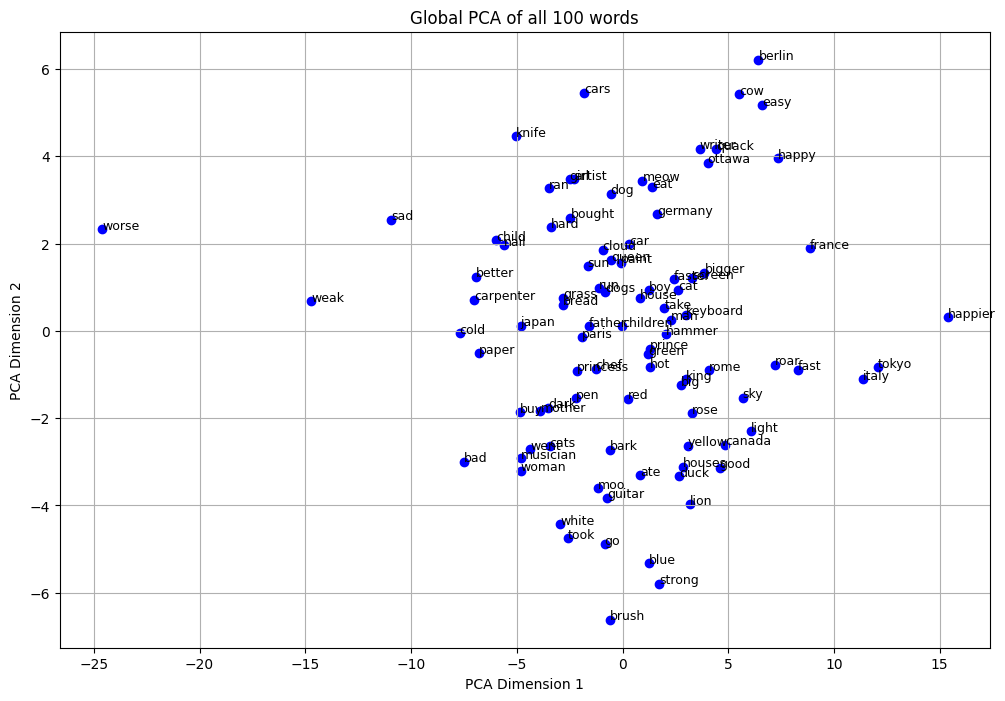

In [14]:
# plotting results of above PCA
plt.figure(figsize=(12, 8))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], color='blue')

for i, word in enumerate(all_words):
    plt.text(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], word, fontsize=9)

plt.title("Global PCA of all 100 words")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid(True)
plt.show()


<ipython-input-15-b55c63eed77d>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = cm.get_cmap('tab20')


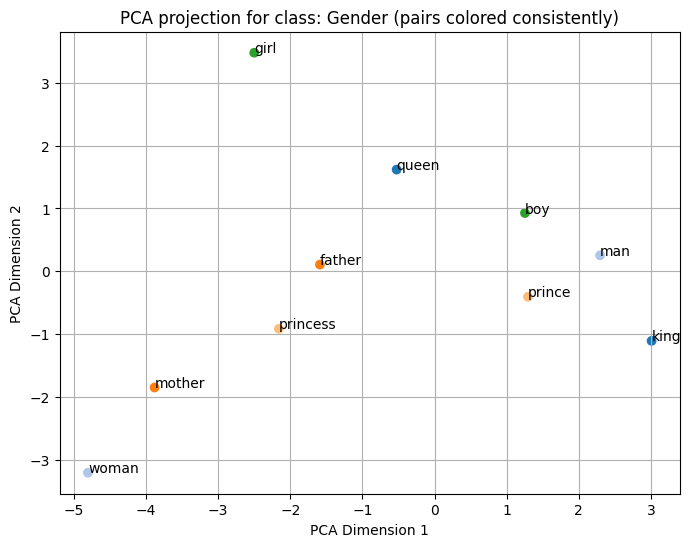

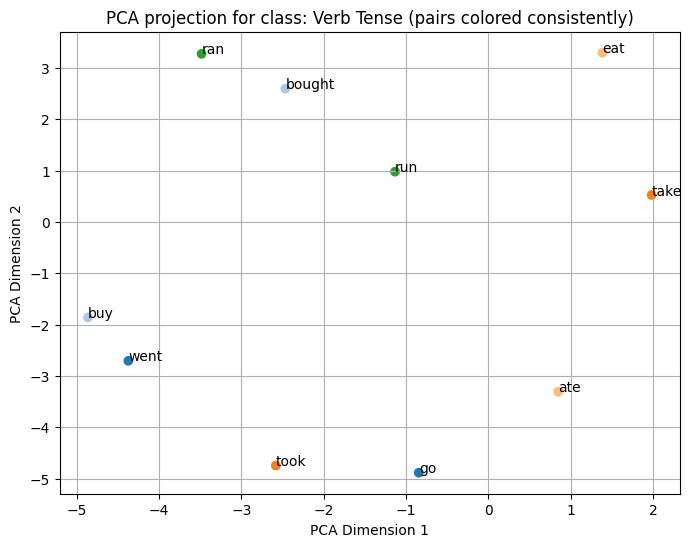

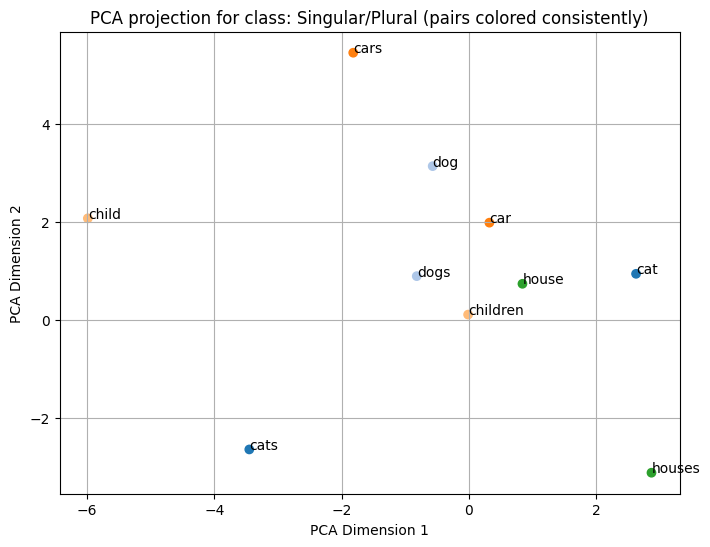

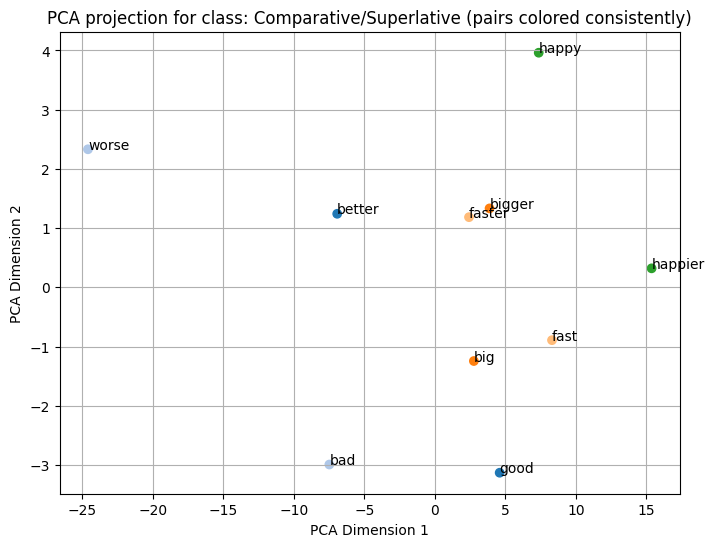

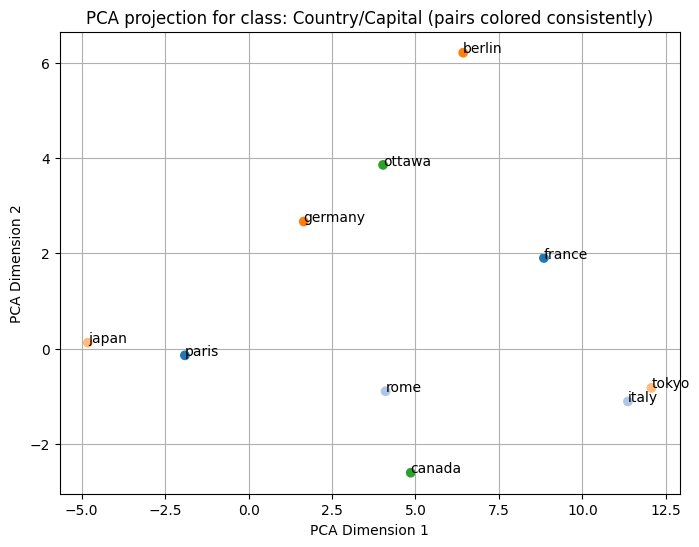

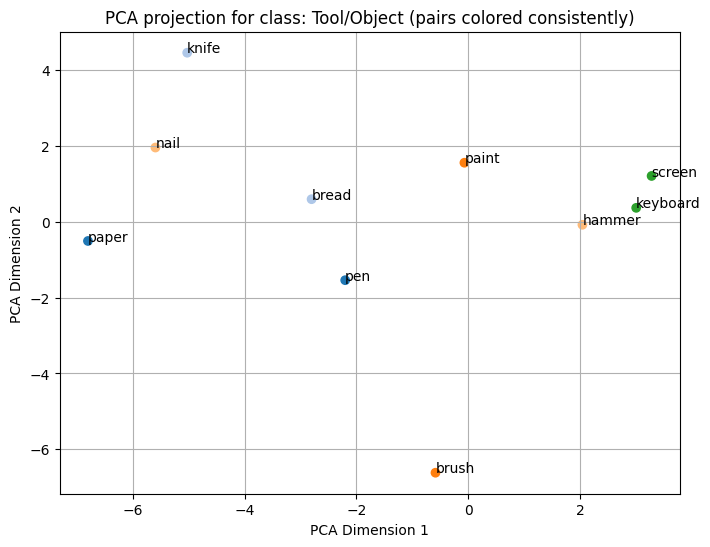

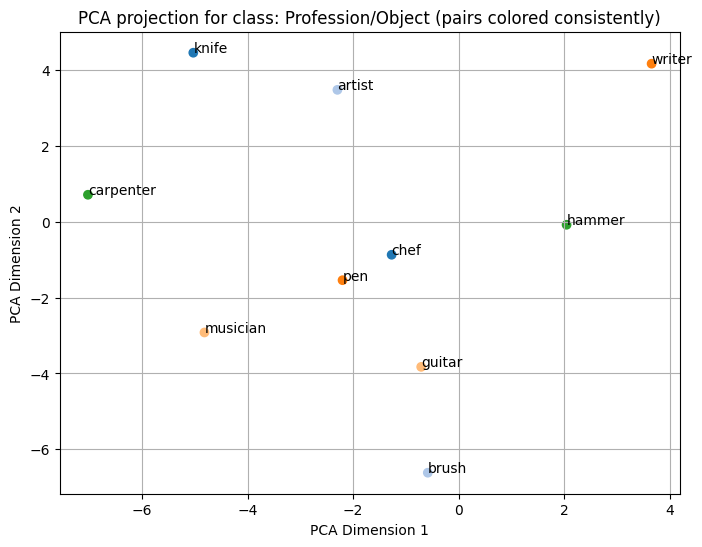

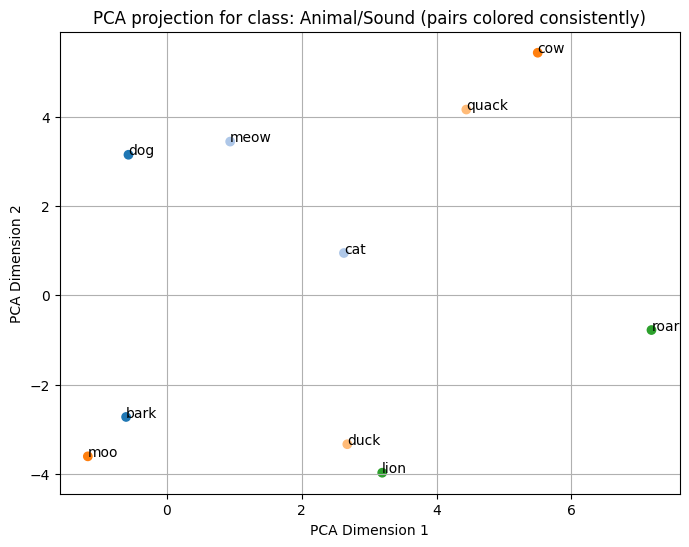

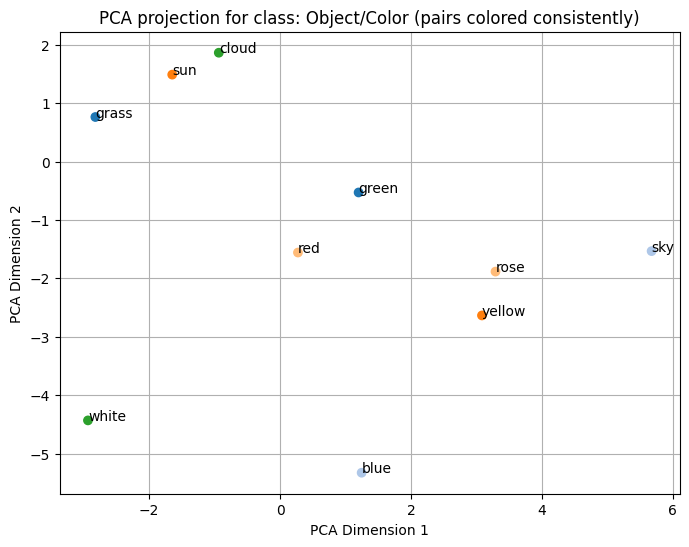

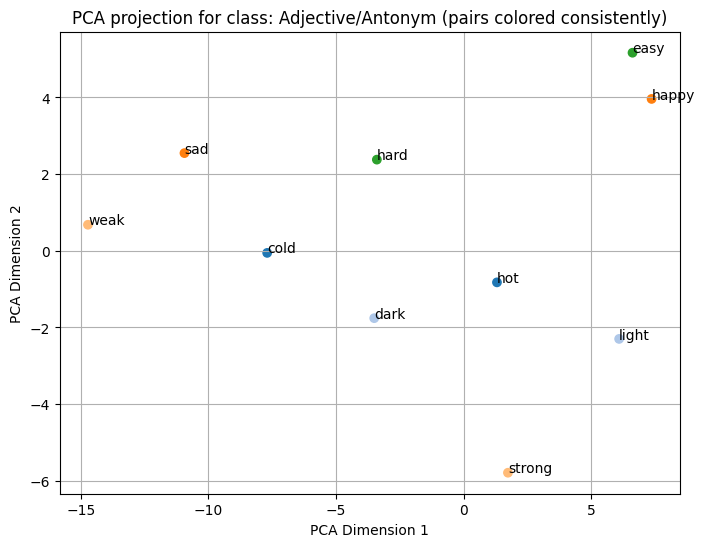

In [15]:
# analogous procedure for plotting PCA (for 10 words)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# defining PCA
pca = PCA(n_components=2)

# defining function mapping word to its PCA 2D coordinates
word_to_coord = {w: word_embeddings_2d[i] for i, w in enumerate(all_words)}

# defining function which will be helpful in giving diffrent colors for diffrent pairs
def get_colors(num_pairs):
    base_cmap = cm.get_cmap('tab20')
    colors = [base_cmap(i % 20) for i in range(num_pairs)]
    return colors

pair_colors = []
pair_index = 0
pair_color_map = {}

# giving unique color to each pair
for class_name, pairs in valid_classes.items():
    colors = get_colors(len(pairs))
    for i, (w1, w2) in enumerate(pairs):
        c = colors[i]
        pair_color_map[(w1, w2)] = c



# generating 10 plots representing PCA
for class_name, pairs in valid_classes.items():
    plt.figure(figsize=(8, 6))
    plt.title(f"PCA projection for class: {class_name} (pairs colored consistently)")
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.grid(True)

    colors = get_colors(len(pairs))

    for i, (w1, w2) in enumerate(pairs):
        c = colors[i]
        x1, y1 = word_to_coord[w1]
        x2, y2 = word_to_coord[w2]
        plt.scatter([x1, x2], [y1, y2], color=[c, c])
        plt.text(x1, y1, w1, fontsize=10)
        plt.text(x2, y2, w2, fontsize=10)

    plt.show()


<ipython-input-16-57d2a0deae46>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_pairs)


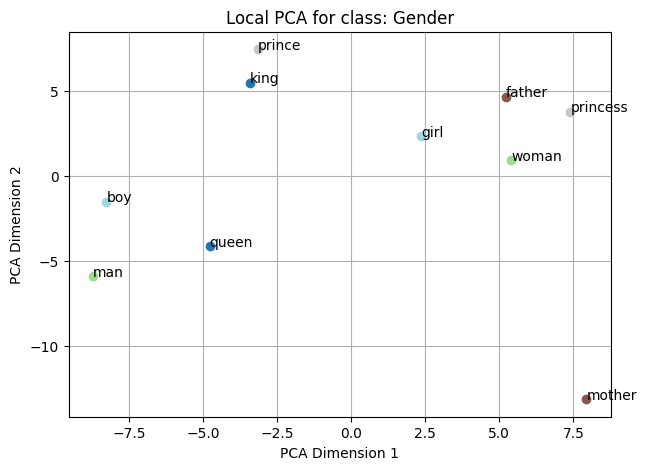

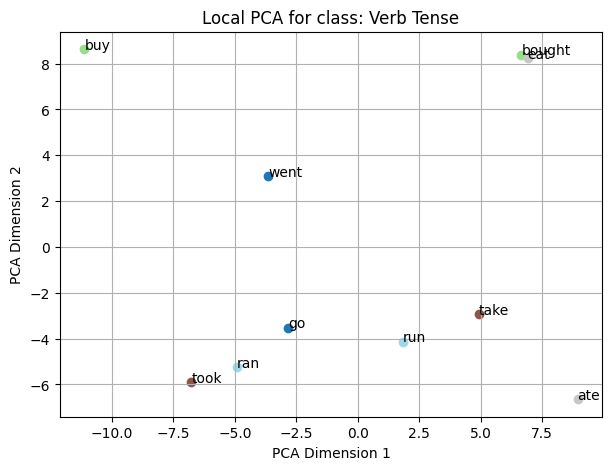

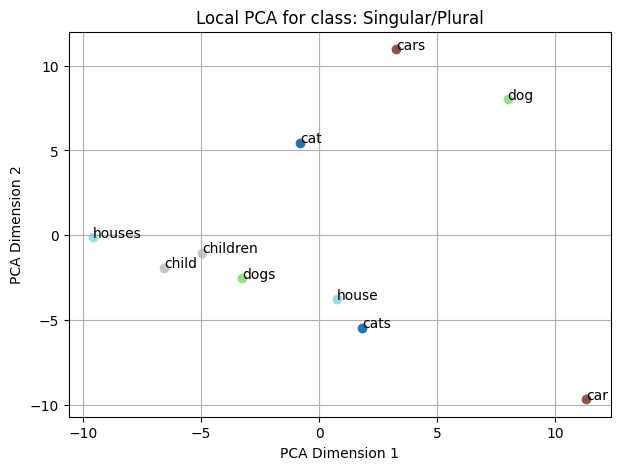

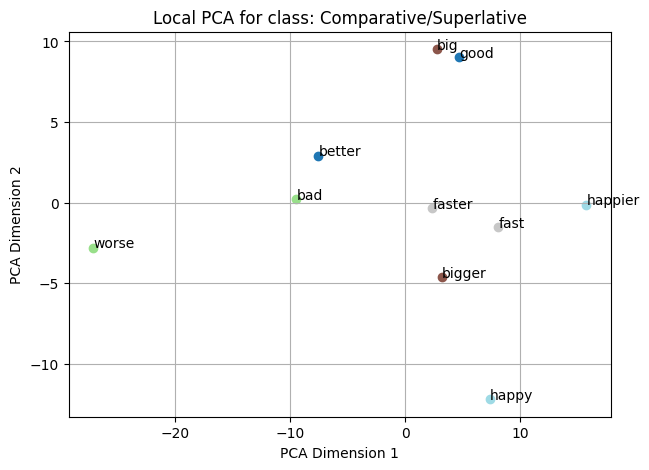

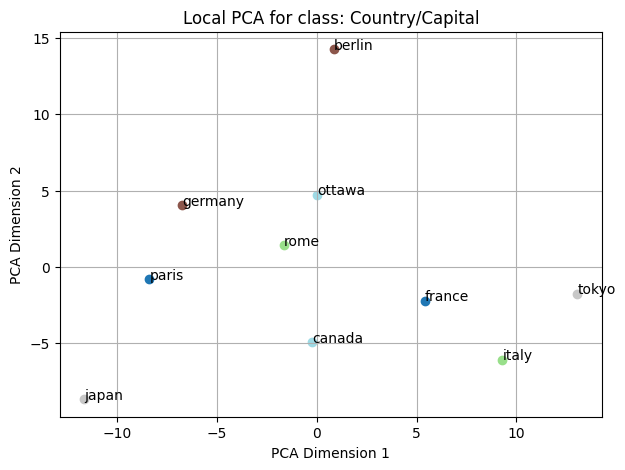

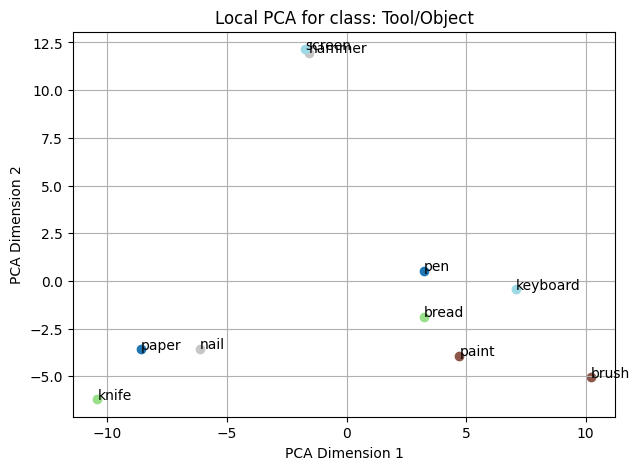

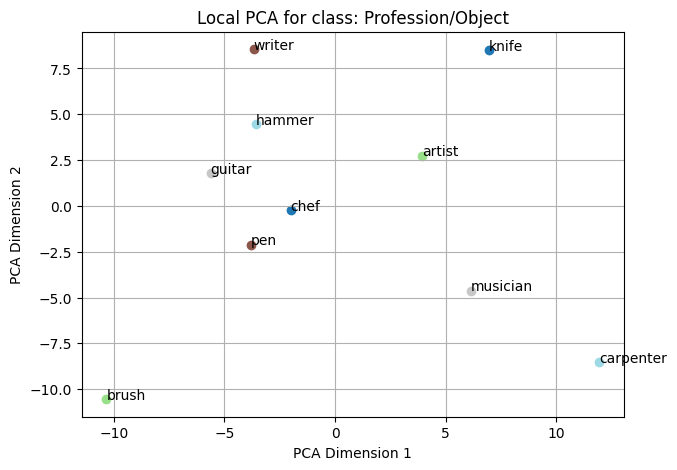

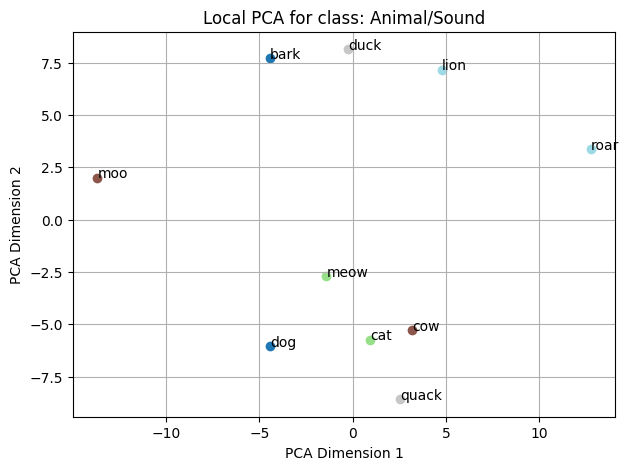

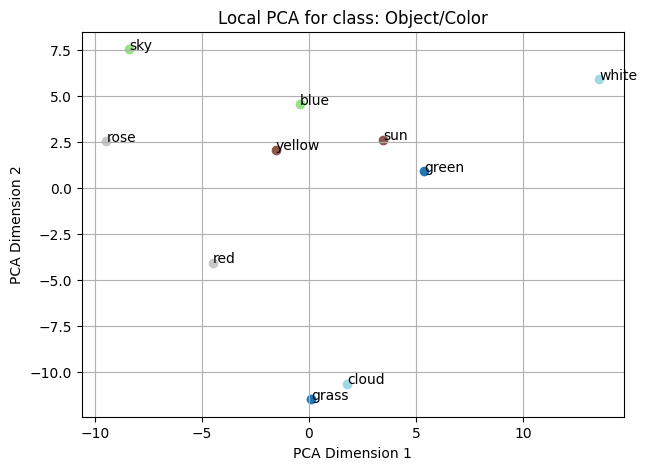

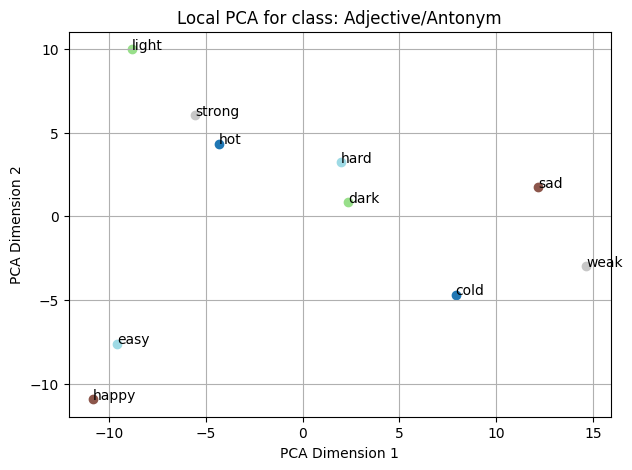

In [16]:
# analogous procedure for plotting LOCAL PCA (for 10 words)

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm

def get_pair_colors(num_pairs=5):
    cmap = cm.get_cmap('tab20', num_pairs)
    return [cmap(i) for i in range(num_pairs)]

pair_colors = get_pair_colors(5)

# loop for each class
for class_name, pairs in valid_classes.items():
    class_words = []
    for w1, w2 in pairs:
        class_words.append(w1)
        class_words.append(w2)

    class_word_ids = [vocab[w] for w in class_words]
    class_embeddings = embeddings[class_word_ids]

    # performing PCA for 10 words only
    pca = PCA(n_components=2)
    class_emb_2d = pca.fit_transform(class_embeddings)

    word_to_coord = {w: class_emb_2d[i] for i, w in enumerate(class_words)}

    # plotting Local PCA
    plt.figure(figsize=(7, 5))
    plt.title(f"Local PCA for class: {class_name}")
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.grid(True)

    for i, (w1, w2) in enumerate(pairs):
        color = pair_colors[i]
        x1, y1 = word_to_coord[w1]
        x2, y2 = word_to_coord[w2]
        plt.scatter(x1, y1, color=color)
        plt.scatter(x2, y2, color=color)
        plt.text(x1, y1, w1, fontsize=10)
        plt.text(x2, y2, w2, fontsize=10)

    plt.show()


In [ ]:
# defining fuction which maps index to word
#id_to_word_temp = {idx: word for word, idx in vocab.items()}
#embedding_matrix = net_64.embedding.weight.data.cpu()
#N = embedding_matrix.shape[0]
#id_to_word = {i: id_to_word_temp.get(i, '<UNK>') for i in range(N)}

In [17]:
# defining fuction which maps index to word
id_to_word = {idx: word for word, idx in vocab.items()}
embedding_matrix = net_64.embedding.weight.data.cpu()

embedding_matrix = embedding_matrix / embedding_matrix.norm(p=2, dim=1, keepdim=True)


In [18]:
import torch

# defining function which finds "topk" nearest words to certain embedding vectior v
def find_nearest_words(v, embedding_matrix, id_to_word, topk=5):
    # we use Euclidean measure
    dists = torch.norm(embedding_matrix - v.unsqueeze(0), dim=1)

    # technically, we find more words (so we take k=topk*10): we may need them if <UNK> will be present in "topk" nearest words
    topk_ids = torch.topk(dists, k=topk*10, largest=False).indices

    results = []
    for idx in topk_ids:
        word = id_to_word.get(idx.item(), '<UNK>')
        # checking whether word =/= UNK
        if word != '<UNK>':
          results.append((word, dists[idx].item()))
        if len(results) == topk:
            break

    return results

# defining function which obtains embedding of the word
def get_embedding(word, vocab, embedding_matrix, unk_id=1):
    idx = vocab.get(word, unk_id)
    vec = embedding_matrix[idx]
    # normalizing
    #vec = vec / vec.norm(p=2)
    return vec


In [32]:

A = "man"
B = "boy"
C = "girl"

v = get_embedding(A, vocab, embedding_matrix)- get_embedding(B, vocab, embedding_matrix)+ get_embedding(C, vocab, embedding_matrix)

nearest = find_nearest_words(v, embedding_matrix, id_to_word, topk=5)

print("Top 5 nearest words:")
for word, dist in nearest:
    print(f"  {word:15} dist = {dist:.4f}")


Top 5 nearest words:
  girl            dist = 1.3358
  man             dist = 1.4534
  insurance       dist = 1.7392
  employers       dist = 1.7422
  defensive       dist = 1.7465


In [27]:
embedding_women = get_embedding("queen", vocab, embedding_matrix)
l2_dist = torch.norm(v - embedding_women).item()
print(f"L2 distance to 'women': {l2_dist:.4f}")

L2 distance to 'women': 2.0385


In [33]:
A = "took"
B = "take"
C = "run"

v = get_embedding(A, vocab, embedding_matrix)- get_embedding(B, vocab, embedding_matrix)+ get_embedding(C, vocab, embedding_matrix)

nearest = find_nearest_words(v, embedding_matrix, id_to_word, topk=5)

print("Top 5 nearest words:")
for word, dist in nearest:
    print(f"  {word:15} dist = {dist:.4f}")

Top 5 nearest words:
  took            dist = 1.3835
  run             dist = 1.4355
  cutlery         dist = 1.7964
  cupboards       dist = 1.8136
  dearth          dist = 1.8208


In [36]:
A = "cars"
B = "houses"
C = "house"

v = get_embedding(A, vocab, embedding_matrix)- get_embedding(B, vocab, embedding_matrix)+ get_embedding(C, vocab, embedding_matrix)

nearest = find_nearest_words(v, embedding_matrix, id_to_word, topk=5)

print("Top 5 nearest words:")
for word, dist in nearest:
    print(f"  {word:15} dist = {dist:.4f}")

Top 5 nearest words:
  house           dist = 1.3947
  cars            dist = 1.4373
  tackling        dist = 1.7380
  shanna          dist = 1.7495
  reflect         dist = 1.7665


In [37]:
A = "bigger"
B = "faster"
C = "fast"

v = get_embedding(A, vocab, embedding_matrix)- get_embedding(B, vocab, embedding_matrix)+ get_embedding(C, vocab, embedding_matrix)

nearest = find_nearest_words(v, embedding_matrix, id_to_word, topk=5)

print("Top 5 nearest words:")
for word, dist in nearest:
    print(f"  {word:15} dist = {dist:.4f}")

Top 5 nearest words:
  fast            dist = 1.3409
  bigger          dist = 1.4120
  vegans          dist = 1.6889
  rey             dist = 1.6947
  exceeds         dist = 1.6975


In [38]:
A = "paris"
B = "france"
C = "berlin"

v = get_embedding(A, vocab, embedding_matrix)- get_embedding(B, vocab, embedding_matrix)+ get_embedding(C, vocab, embedding_matrix)

nearest = find_nearest_words(v, embedding_matrix, id_to_word, topk=5)

print("Top 5 nearest words:")
for word, dist in nearest:
    print(f"  {word:15} dist = {dist:.4f}")

Top 5 nearest words:
  paris           dist = 1.2731
  berlin          dist = 1.4140
  modifier        dist = 1.6802
  testicles       dist = 1.6830
  wishful         dist = 1.7158


In [39]:
A = "paper"
B = "pen"
C = "bread"

v = get_embedding(A, vocab, embedding_matrix)- get_embedding(B, vocab, embedding_matrix)+ get_embedding(C, vocab, embedding_matrix)

nearest = find_nearest_words(v, embedding_matrix, id_to_word, topk=5)

print("Top 5 nearest words:")
for word, dist in nearest:
    print(f"  {word:15} dist = {dist:.4f}")

Top 5 nearest words:
  paper           dist = 1.3386
  bread           dist = 1.4281
  gavin           dist = 1.6577
  watery          dist = 1.6670
  piggly          dist = 1.6707


In [42]:
A = "hammer"
B = "carpenter"
C = "musician"

v = get_embedding(A, vocab, embedding_matrix)- get_embedding(B, vocab, embedding_matrix)+ get_embedding(C, vocab, embedding_matrix)

nearest = find_nearest_words(v, embedding_matrix, id_to_word, topk=5)

print("Top 5 nearest words:")
for word, dist in nearest:
    print(f"  {word:15} dist = {dist:.4f}")

Top 5 nearest words:
  hammer          dist = 1.3283
  musician        dist = 1.4494
  nurturing       dist = 1.7250
  wisconsinites   dist = 1.7362
  acacia          dist = 1.7514


In [43]:
A = "dog"
B = "bark"
C = "quack"

v = get_embedding(A, vocab, embedding_matrix)- get_embedding(B, vocab, embedding_matrix)+ get_embedding(C, vocab, embedding_matrix)

nearest = find_nearest_words(v, embedding_matrix, id_to_word, topk=5)

print("Top 5 nearest words:")
for word, dist in nearest:
    print(f"  {word:15} dist = {dist:.4f}")

Top 5 nearest words:
  quack           dist = 1.4592
  dog             dist = 1.4612
  saltiness       dist = 1.8357
  restr           dist = 1.8586
  habanero        dist = 1.8684


In [44]:
A = "grass"
B = "green"
C = "white"

v = get_embedding(A, vocab, embedding_matrix)- get_embedding(B, vocab, embedding_matrix)+ get_embedding(C, vocab, embedding_matrix)

nearest = find_nearest_words(v, embedding_matrix, id_to_word, topk=5)

print("Top 5 nearest words:")
for word, dist in nearest:
    print(f"  {word:15} dist = {dist:.4f}")

Top 5 nearest words:
  grass           dist = 1.3226
  white           dist = 1.4326
  nhabanero       dist = 1.6703
  unapologetic    dist = 1.6787
  forgetful       dist = 1.6858


In [45]:
A = "cold"
B = "hot"
C = "light"

v = get_embedding(A, vocab, embedding_matrix)- get_embedding(B, vocab, embedding_matrix)+ get_embedding(C, vocab, embedding_matrix)

nearest = find_nearest_words(v, embedding_matrix, id_to_word, topk=5)

print("Top 5 nearest words:")
for word, dist in nearest:
    print(f"  {word:15} dist = {dist:.4f}")

Top 5 nearest words:
  cold            dist = 1.3972
  light           dist = 1.4406
  zzzzz           dist = 1.6848
  immersion       dist = 1.6899
  skybox          dist = 1.6953
